# SacFC Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 27, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [3]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [9]:
lkupclientid = 31 # sacfc

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11509 entries, 0 to 11508
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              11509 non-null  int64  
 1   dimCustomerMasterId       11509 non-null  int64  
 2   customerNumber            666 non-null    object 
 3   year                      11509 non-null  object 
 4   productGrouping           11509 non-null  object 
 5   totalSpent                11509 non-null  float64
 6   recentDate                11509 non-null  object 
 7   attendancePercent         11509 non-null  float64
 8   renewedBeforeDays         11509 non-null  int64  
 9   isBuyer                   11509 non-null  object 
 10  source_tenure             11509 non-null  int64  
 11  tenure                    11509 non-null  int64  
 12  distToVenue               0 non-null      object 
 13  totalGames                11509 non-null  int64  
 14  recenc

### Let's drop the features that have lots of null values:

In [10]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'customerNumber',
    'distToVenue',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11509 entries, 0 to 11508
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          11509 non-null  int64  
 1   dimCustomerMasterId   11509 non-null  int64  
 2   year                  11509 non-null  object 
 3   productGrouping       11509 non-null  object 
 4   totalSpent            11509 non-null  float64
 5   recentDate            11509 non-null  object 
 6   attendancePercent     11509 non-null  float64
 7   renewedBeforeDays     11509 non-null  int64  
 8   isBuyer               11509 non-null  object 
 9   source_tenure         11509 non-null  int64  
 10  tenure                11509 non-null  int64  
 11  totalGames            11509 non-null  int64  
 12  recency               11509 non-null  int64  
 13  missed_games_1        11509 non-null  int64  
 14  missed_games_2        11509 non-null  int64  
 15  missed_games_over_2

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [11]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (10358, 45)
Unseen Data For Predictions: (1151, 45)
Data for Modeling (A Class): (10358, 45)
Unseen Data For Predictions: (1151, 45)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [12]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(11509, 31)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [13]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11509 entries, 0 to 11508
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   attendancePercent    11509 non-null  float64
 1   renewedBeforeDays    11509 non-null  int64  
 2   source_tenure        11509 non-null  int64  
 3   tenure               11509 non-null  int64  
 4   totalGames           11509 non-null  int64  
 5   recency              11509 non-null  int64  
 6   missed_games_1       11509 non-null  int64  
 7   missed_games_2       11509 non-null  int64  
 8   missed_games_over_2  11509 non-null  int64  
 9   click_link           11509 non-null  int64  
 10  open_email           11509 non-null  int64  
 11  send_email           11509 non-null  int64  
 12  openToSendRatio      11509 non-null  float64
 13  clickToSendRatio     11509 non-null  float64
 14  email                11509 non-null  int64  
 15  internal_note        11509 non-null 

### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [14]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,attendancePercent,renewedBeforeDays,source_tenure,tenure,totalGames,recency,missed_games_1,missed_games_2,missed_games_over_2,click_link,open_email,send_email,openToSendRatio,clickToSendRatio,email,internal_note,phonecall,isNextYear_Buyer
attendancePercent,1.00,-0.18,0.07,0.07,0.19,-0.33,0.02,-0.06,-0.40,0.10,0.09,0.01,0.14,0.15,0.02,0.02,0.01,0.16
renewedBeforeDays,-0.18,1.00,0.41,0.42,0.24,0.02,0.15,0.06,0.14,0.29,0.35,0.52,0.19,0.17,0.06,-0.02,0.05,-0.42
source_tenure,0.07,0.41,1.00,0.99,0.04,-0.11,0.02,-0.07,-0.03,0.24,0.28,0.37,0.20,0.18,0.01,0.00,0.01,-0.14
tenure,0.07,0.42,0.99,1.00,0.04,-0.11,0.02,-0.07,-0.03,0.24,0.28,0.37,0.20,0.18,0.01,-0.00,0.01,-0.14
totalGames,0.19,0.24,0.04,0.04,1.00,-0.11,0.50,0.32,0.00,0.12,0.09,0.12,0.01,0.07,0.11,0.05,0.11,0.14
recency,-0.33,0.02,-0.11,-0.11,-0.11,1.00,-0.07,0.07,0.42,-0.13,-0.15,-0.13,-0.16,-0.14,-0.05,-0.00,-0.02,-0.07
missed_games_1,0.02,0.15,0.02,0.02,0.50,-0.07,1.00,0.15,-0.14,0.04,0.03,0.10,-0.02,0.01,0.06,0.03,0.08,0.09
missed_games_2,-0.06,0.06,-0.07,-0.07,0.32,0.07,0.15,1.00,-0.02,-0.07,-0.09,-0.11,-0.10,-0.07,0.01,0.02,0.02,0.08
missed_games_over_2,-0.40,0.14,-0.03,-0.03,0.00,0.42,-0.14,-0.02,1.00,-0.12,-0.11,-0.01,-0.16,-0.17,0.01,0.00,0.04,-0.09
click_link,0.10,0.29,0.24,0.24,0.12,-0.13,0.04,-0.07,-0.12,1.00,0.53,0.44,0.41,0.88,0.07,0.00,0.04,-0.16


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [15]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (9207, 18)
Unseen Data For Predictions: (2302, 18)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [16]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "attendancePercent",
        "source_tenure",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2"
    ]
)

,Description,Value
0,session_id,1011
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(9207, 18)"
5,Missing Values,False
6,Numeric Features,16
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


(StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
 'isNextYear_Buyer',
 False,
 [('Setup Config',
                                  Description             Value
   0                               session_id              1011
   1                                   Target  isNextYear_Buyer
   2                              Target Type            Binary
   3                            Label Encoded        0: 0, 1: 1
   4                            Original Data        (9207, 18)
   5                           Missing Values             False
   6                         Numeric Features                16
   7                     Categorical Features                 1
   8                         Ordinal Features             False
   9                High Cardinality Features             False
   10                 High Cardinality Method              None
   11                   Transformed Train Set        (7365, 34)
   12                    Transformed Test Set        (1

In [17]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
5,Light Gradient Boosting Machine,0.8868,0.9487,0.9231,0.8941,0.9083,0.7604,0.7613,0.0620
9,Extreme Gradient Boosting,0.8850,0.9462,0.9229,0.8917,0.9069,0.7566,0.7576,0.6950
7,Random Forest Classifier,0.8751,0.9421,0.9249,0.8765,0.9000,0.7340,0.7362,0.3170
2,Gradient Boosting Classifier,0.8665,0.9366,0.9170,0.8705,0.8930,0.7159,0.7181,0.3470
3,Extra Trees Classifier,0.8539,0.9236,0.9199,0.8517,0.8844,0.6868,0.6910,0.2690
0,Ada Boost Classifier,0.8425,0.9214,0.9032,0.8478,0.8745,0.6637,0.6665,0.1000
1,Decision Tree Classifier,0.8288,0.8209,0.8576,0.8602,0.8588,0.6413,0.6415,0.0210
8,NGBClassifier,0.8243,0.9155,0.9457,0.8015,0.8674,0.6123,0.6320,3.3160
4,K Neighbors Classifier,0.8023,0.8605,0.8701,0.8166,0.8424,0.5780,0.5805,0.0530
6,Logistic Regression,0.7594,0.8190,0.8907,0.7565,0.8180,0.4699,0.4842,0.2470


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [18]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8982,0.9594,0.9174,0.9154,0.9164,0.7864,0.7864
1,0.8833,0.9492,0.9174,0.8935,0.9053,0.7534,0.7539
2,0.9023,0.9448,0.9284,0.9121,0.9202,0.7943,0.7945
3,0.8887,0.9508,0.9306,0.8908,0.9103,0.7640,0.7653
4,0.8738,0.9404,0.9306,0.8703,0.8995,0.7306,0.7335
5,0.8927,0.9443,0.9284,0.8983,0.9131,0.7729,0.7736
6,0.8981,0.9597,0.9262,0.9079,0.9169,0.7852,0.7854
7,0.8736,0.9431,0.9172,0.8798,0.8981,0.7320,0.7331
8,0.8723,0.9410,0.9217,0.8747,0.8976,0.7282,0.7300
9,0.8845,0.9542,0.9128,0.8987,0.9057,0.7568,0.7570


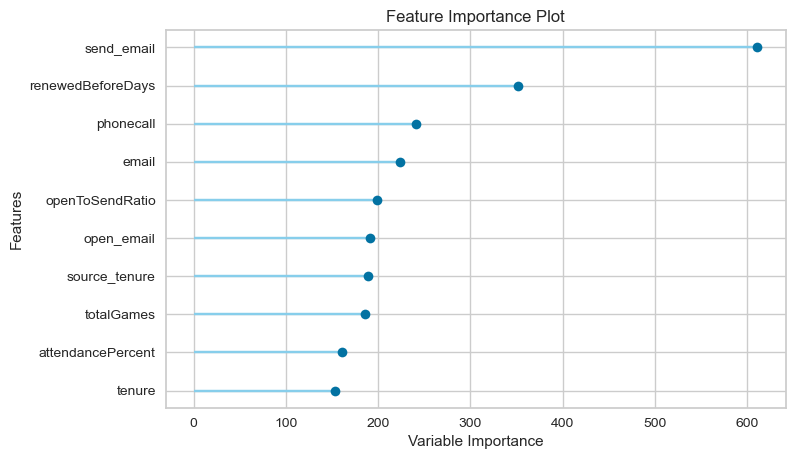

In [19]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?